<a href="https://colab.research.google.com/github/Naikaru/AI_MusicTransformer/blob/master/Music_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Artificial Intelligence Project ~ Music Transformer

## 1 - Preprocessing

In [0]:
from google.colab import drive

drive.mount('/gdrive')
gdrive_root = '/gdrive/My Drive'
gdrive_data = '/gdrive/My Drive/my_data'

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [0]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Sat_Aug_25_21:08:01_CDT_2018
Cuda compilation tools, release 10.0, V10.0.130


In [0]:
import pickle
import os
import sys
import math
import random
import pickle
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Hyperparameters

In [0]:
d_model = 512
nhead = 8
dim_feedforward = 1024
dropout = 0.2
num_layer = 6
batch_size = 8
sequence_length = 1024
warmup_steps = 4000
pad_token = 1   
# vocabulary_size = 388 # depends on the dataset

In [0]:
#Import library for encoder function

!ls /gdrive/My\ Drive/my_data/library/processor.py
!cat '/gdrive/My Drive/my_data/library/processor.py'

sys.path.append('/gdrive/My Drive/my_data/library')

from processor import encode_midi, decode_midi

'/gdrive/My Drive/my_data/library/processor.py'
import pretty_midi


RANGE_NOTE_ON = 128
RANGE_NOTE_OFF = 128
RANGE_VEL = 32
RANGE_TIME_SHIFT = 100

START_IDX = {
    'note_on': 0,
    'note_off': RANGE_NOTE_ON,
    'time_shift': RANGE_NOTE_ON + RANGE_NOTE_OFF,
    'velocity': RANGE_NOTE_ON + RANGE_NOTE_OFF + RANGE_TIME_SHIFT
}


class SustainAdapter:
    def __init__(self, time, type):
        self.start =  time
        self.type = type


class SustainDownManager:
    def __init__(self, start, end):
        self.start = start
        self.end = end
        self.managed_notes = []
        self._note_dict = {} # key: pitch, value: note.start

    def add_managed_note(self, note: pretty_midi.Note):
        self.managed_notes.append(note)

    def transposition_notes(self):
        for note in reversed(self.managed_notes):
            try:
                note.end = self._note_dict[note.pitch]
            except KeyError:
                note.end = max(self.end, note.end)
            self

In [0]:
def encode_midi_files(midi_dir_path, save_dir_path, extension):
  #create directory for saving files
  os.makedirs(save_dir_path, exist_ok=True)
  #get all midi files from midi_directory
  for file in os.listdir(midi_dir_path):
    if file.endswith(tuple(extension)):
        print(os.path.join(midi_dir_path, file))
        print(file + ' is being processed', flush=True)
        try:
          encoded_file = encode_midi(midi_dir_path+file)
        except KeyboardInterrupt:
            print(' Stopped by keyboard')
            return
        except EOFError:
            print('EOF Error')
            return
        with open(save_dir_path+file+'.encoded', 'wb') as f:
            pickle.dump(encoded_file, f)


In [0]:
midi_dir_path = '/gdrive/My Drive/my_data/midi_files/'
save_dir_path = '/gdrive/My Drive/my_data/encoded_midi/'
train_dir_path = '/gdrive/My Drive/my_data/training_set/'
test_dir_path = '/gdrive/My Drive/my_data/test_set/'
extension = ['.mid', '.midi']

In [0]:
# encode_midi_files(midi_dir_path, save_dir_path, extension)

In [0]:
import shutil

def create_dataset(save_dir_path, split_ratio=0.9):
    dataset = [file for file in os.listdir(save_dir_path)]
    np.random.shuffle(dataset)

    train_set = dataset[:int(len(dataset) * split_ratio)]    
    test_set = dataset[int(len(dataset) * split_ratio):]
    
    shutil.rmtree(train_dir_path)
    shutil.rmtree(test_dir_path)

    os.makedirs(train_dir_path, exist_ok=True)
    os.makedirs(test_dir_path, exist_ok=True)

    for file in os.listdir(save_dir_path):
        if os.stat(save_dir_path+file).st_size != 0:
            if file in test_set:
                shutil.copyfile(save_dir_path+file, test_dir_path+file)
            else:
                shutil.copyfile(save_dir_path+file, train_dir_path+file)


In [0]:
# create_dataset(save_dir_path, split_ratio=0.9)

In [0]:
def load_dataset(train_dir_path, test_dir_path):
    #load all encoded file
    train_set = [file for file in os.listdir(train_dir_path)]
    test_set = [file for file in os.listdir(test_dir_path)]

    return train_set, test_set

In [0]:
# train_data, test_data = load_dataset(train_dir_path, test_dir_path)

In [0]:
def generate_batch(dataset, dir_path, sequence_length=1024, batch_size=8):
    sequence_length += 1
    batch_midi = []
    while len(batch_midi) < batch_size:
        file = random.choice(dataset)
        #if the midi contains more sequence that the sequence length
        try:
            with open(dir_path+file, 'rb') as f:
                data = pickle.load(f)
        except:
            print(dir_path+file + " file not found.")
        if sequence_length <= len(data):
            begin_index = random.randrange(0, len(data) - sequence_length)
            data = data[begin_index:begin_index + sequence_length]
            batch_midi.append(data)
    batch_midi = torch.Tensor(batch_midi)
    inputs = batch_midi[:, :-1]
    labels = batch_midi[:, 1:]
    return inputs, labels

In [0]:
# x, y = generate_batch(train_data, train_dir_path, sequence_length=sequence_length, batch_size=batch_size)

## 2 - Attention

In [0]:
class MusicMultiheadAttention(torch.nn.MultiheadAttention):
    def __init__(self, embed_dim, nhead, dropout=0.1, bias=True, add_bias_kv=False, 
                 add_zero_attn=False, kdim=None, vdim=None):
        
        torch.nn.MultiheadAttention.__init__(self, embed_dim, nhead, dropout=0.1, 
                                             bias=True, add_bias_kv=False, 
                                             add_zero_attn=False, kdim=None, vdim=None)
        
        self.embed_dim = embed_dim
        self.weights_q = torch.nn.Linear(self.embed_dim, self.embed_dim)
        self.weights_k = torch.nn.Linear(self.embed_dim, self.embed_dim)
        self.weights_v = torch.nn.Linear(self.embed_dim, self.embed_dim)
        self.weights_o = torch.nn.Linear(self.embed_dim, self.embed_dim)

    def forward(self, query, key, value, key_padding_mask=None,
                need_weights=True, attn_mask=None):
        Q, K, V = self.transform_input(query, key, value)
        # Reshaping the matrices 
        # Each L × D query, key, and value matrix is then split into H L × D 
        # h_D parts or attention heads, indexed by h, and with dimension D_h = D/H
        Q = self.matrix_to_heads(Q)
        K = self.matrix_to_heads(K)
        V = self.matrix_to_heads(V)
        
        # learning a separate relative position embedding Er of shape (H, L, Dh)
        Er = torch.randn([self.num_heads, query.size(1), self.head_dim], requires_grad=False).to(device)

        # we transpose the two last dimensions of Er to realize Q*Er^T 
        QEr = torch.matmul(Q, torch.transpose(Er,1,2))
        # QEr of shape (B, H, L, L)     
        # QEr = torch.einsum('bhld,ld->bhll', [Q, Er])

        # 1. Pad a dummy column vector of length L before the leftmost column.
        QEr = torch.nn.functional.pad(QEr, (1,0), mode="constant", value=0)

        # 2. Reshape the matrix to have shape (L+1, L). 
        QEr = torch.reshape(QEr, [QEr.size(0), QEr.size(1), QEr.size(3), QEr.size(2)])
        
        # 3. Slice that matrix to retain only the last l rows and all the columns, 
        # resulting in a (L, L) matrix again, but now absolute-by-absolute indexed, 
        # which is the S rel that we need.
        S_rel = QEr[:,:,1:,:]

        z_attention = self.attention(Q, K, V, S_rel, attn_mask)
        z_attention = self.weights_o(z_attention)
        # Masking can be added and Dropout ?

        return z_attention

    def attention(self, Q, K, V, S, mask):
        # Dh = self.head_dim // self.num_heads
        logits = torch.add(torch.matmul(Q, torch.transpose(K, 2, 3)), S) / math.sqrt((self.head_dim // self.num_heads))
        # print("logits : ", logits.size())
        # print("mask : ", mask.size())
        if mask is not None:
        #    mask = mask.unsqueeze(1) #shape of mask must be broadcastable with shape of underlying tensor
            logits = logits.masked_fill(mask == 0, -1e9) #masked_fill fills elements of scores with -1e9 where mask == 0
        #if mask is not None:
        #    logits += (mask.to(torch.int64) * -1e9).to(logits.dtype)        
            
        activation = F.softmax(logits, -1)
        attention = torch.matmul(activation, V)
        attention = torch.reshape(attention, (attention.size(0), -1, self.embed_dim))
        return attention
    
    def matrix_to_heads(self, qkv):
        '''
            Takes a query/key/value (qkv) matrix and reshapes it to  B * H * L * D_h heads 
            with dimension D_h = D/H
        '''
        batch_size_q = qkv.size(0)
        #qkv = torch.reshape(qkv, (batch_size_q, qkv.size(0), self.num_heads, self.head_dim))
        qkv = torch.reshape(qkv, (batch_size_q, self.num_heads, qkv.size(1), self.head_dim))
        return qkv

    def transform_input(self, query, key, value):
        '''
            Transforming the input vector, X, of LxD dimension 
            into 
                queries: Q = XW^Q 
                keys:    K = XW^K
            and values:  V = XW^V
            which are all DxD square matrices.
        '''
        return self.weights_q(query), self.weights_k(key), self.weights_v(value)
    

class MusicTransformerEncoderLayer(torch.nn.TransformerEncoderLayer):
    def __init__(self, d_model, nhead, dim_feedforward=2048,
                 dropout=0.1, activation="relu"):
        torch.nn.TransformerEncoderLayer.__init__(self, d_model, nhead)
        self.d_model = d_model
        # OverRide
        self.self_attn = MusicMultiheadAttention(d_model, nhead)

class MusicTransformerDecoderLayer(torch.nn.TransformerDecoderLayer):
    def __init__(self, d_model, nhead, dim_feedforward=2048,
                 dropout=0.1, activation="relu"):
        torch.nn.TransformerDecoderLayer.__init__(self, d_model,nhead)
        self.d_model = d_model
        # OverRide
        self.self_attn = MusicMultiheadAttention(d_model, nhead)

class MusicTransformerEncoder(torch.nn.TransformerEncoder):
    def __init__(self, encoder_layer, vocabulary_size=390, num_encoder_layers=6, normalization=None):
        super().__init__(encoder_layer, num_encoder_layers, normalization)
        self.d_model = encoder_layer.d_model
        self.vocabulary_size = vocabulary_size
        self.dropout = torch.nn.Dropout(encoder_layer.dropout.p)
        self.embedding = torch.nn.Embedding(num_embeddings=self.vocabulary_size, embedding_dim=self.d_model)
    
    def forward(self, src, mask=None, src_key_padding_mask=None):
        
        pos_encoding = DynamicPositionEmbedding(self.d_model, src.size(1))
        
        src = math.sqrt(self.d_model) * self.embedding(src.to(torch.long).to(device))
        src = pos_encoding(src)
        src = self.dropout(src)

        return super().forward(src, mask=mask, src_key_padding_mask=src_key_padding_mask)


class MusicTransformerDecoder(torch.nn.TransformerDecoder):
    def __init__(self, decoder_layer, vocabulary_size=390, num_decoder_layers=6, normalization=None):
        super().__init__(decoder_layer, num_decoder_layers, normalization)
        self.d_model = decoder_layer.d_model
        self.vocabulary_size = vocabulary_size
        self.dropout = torch.nn.Dropout(decoder_layer.dropout.p)
        self.embedding = torch.nn.Embedding(num_embeddings=self.vocabulary_size, embedding_dim=self.d_model)

    def forward(self, tgt, memory, tgt_mask=None, 
                memory_mask=None, tgt_key_padding_mask=None,
                memory_key_padding_mask=None):        
                
        pos_encoding = DynamicPositionEmbedding(self.d_model, tgt.size(1))

        tgt = pos_encoding(math.sqrt(self.d_model) * self.embedding(tgt.to(torch.long).to(device)))
        tgt = self.dropout(tgt)

        return super().forward(tgt, memory, tgt_mask=tgt_mask, 
                memory_mask=memory_mask, tgt_key_padding_mask=tgt_key_padding_mask,
                memory_key_padding_mask=memory_key_padding_mask)


class MusicTransformer(torch.nn.modules.Transformer):
    def __init__(self, d_model=512, nhead=8, vocabulary_size=388,
                 num_encoder_layers=6, num_decoder_layers=6, 
                 dim_feedforward=2048, dropout=0.1, activation="relu", 
                 custom_encoder=None, custom_decoder=None):
        
        super().__init__(d_model=d_model, nhead=nhead, 
                         num_encoder_layers=num_encoder_layers,
                         num_decoder_layers=num_decoder_layers, 
                         dim_feedforward=dim_feedforward, dropout=dropout, activation=activation, 
                         custom_encoder=custom_encoder, custom_decoder=custom_decoder)
        
        self.vocabulary_size = vocabulary_size
        ###        
        self.fc = torch.nn.Linear(self.d_model, self.vocabulary_size)
        self._reset_parameters()

    def forward(self, src, tgt, src_mask=None, tgt_mask=None,
                memory_mask=None, src_key_padding_mask=None,
                tgt_key_padding_mask=None, memory_key_padding_mask=None):

        #if src.size(1) != tgt.size(1):
        #    raise RuntimeError("the batch number of src and tgt must be equal")

        #if src.size(2) != self.d_model or tgt.size(2) != self.d_model:
        #    raise RuntimeError("the feature number of src and tgt must be equal to d_model")
            
        memory = self.encoder(src, mask=src_mask, src_key_padding_mask=src_key_padding_mask)
        output = self.decoder(tgt, memory, tgt_mask=tgt_mask, memory_mask=memory_mask,
                              tgt_key_padding_mask=tgt_key_padding_mask,
                              memory_key_padding_mask=memory_key_padding_mask)

        output = self.fc(output)        
        
        return output




class DynamicPositionEmbedding(torch.nn.Module):
    def __init__(self, embedding_dim, max_seq=1024):
        super().__init__()
        embed_sinusoid_list = np.array([[
            [
                math.sin(
                    pos * math.exp(-math.log(10000) * i/embedding_dim) *
                    math.exp(math.log(10000)/embedding_dim * (i % 2)) + 0.5 * math.pi * (i % 2)
                )
                for i in range(embedding_dim)
            ]
            for pos in range(max_seq)
        ]])
        self.positional_embedding = embed_sinusoid_list

    def forward(self, x):
        x = x + torch.from_numpy(self.positional_embedding[:, :x.size(1), :]).to(x.device, dtype=x.dtype)
        return x


class PositionalEncoder(torch.nn.Module):
    def __init__(self, d_model, max_seq_len=1024):
        super().__init__()
        self.d_model = d_model
        pe = torch.zeros(max_seq_len, d_model)
        for pos in range(max_seq_len):
            for i in range(0, d_model, 2):
                pe[pos, i] = \
                    math.sin(pos / (10000 ** ((2 * i) / d_model)))
                pe[pos, i + 1] = \
                    math.cos(pos / (10000 ** ((2 * (i + 1)) / d_model)))
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        with torch.no_grad():
            x = x * math.sqrt(self.d_model)
            seq_len = x.size(1)
            self.pe.to(device)
            print("self.pe : ", self.pe.device.type)
            pe = self.pe[:, :seq_len]
            print("pe : ", pe.device.type)
            x = x + pe
            return x   

In [0]:
from torch.utils.data.dataset import Dataset

def tensorFromSequence(sequence):
    """
    Generate tensors from the sequence in numpy.
    """
    output = torch.tensor(sequence).long()

    return output


def PrepareData(npz_file, split='train', L=1024):
    """
    Function to prepare the data into pairs (input, target).
    Adds [PAD], [SOS] and [EOS] tokens into the data,
    where [PAD]=1, [SOS]=2, [EOS]=3.
    Limits the sequence to length of L.
    """
    print("Preparing data for",split,"split...")
    # Load in the data
    full_data = np.load(npz_file, fix_imports=True, encoding="latin1", allow_pickle=True)
    data = full_data[split]

    # Extract the vocab from file
    vocab = GenerateVocab(npz_file)
    # Generate new vocab to map to later
    new_vocab = np.arange(len(vocab))

    # Initialize the tokens
    pad_token = np.array([[1]])

    # Repeat for all samples in data
    pairs = []
    for samples in data:
        # Serialise the dataset so that the resulting sequence is
        # S_1 A_1 T_1, B_2 S_2 A_2 T_2 B_2, ...

        # Generate input
        input_seq = samples.flatten()

        # Cut off the samples so that it has length of 1024
        if(len(input_seq) >= L):
            # input_seq = input_seq[:L-1]
            input_seq = input_seq[:L]

        # Set the NaN values to 0 and reshape accordingly
        input_seq = np.nan_to_num(input_seq.reshape(1,input_seq.size))

        # Generate target
        output_seq = input_seq[:,1:]

        # For both sequences, pad to sequence length L
        pad_array = pad_token * np.ones((1,L-input_seq.shape[1]))
        input_seq = np.append(input_seq, pad_array,axis=1)
        pad_array = pad_token * np.ones((1,L-output_seq.shape[1]))
        output_seq = np.append(output_seq, pad_array,axis=1)

        # Map the pitch value to int values below vocab size
        for i, val in enumerate(vocab):
            input_seq[input_seq==val] = new_vocab[i]
            output_seq[output_seq==val] = new_vocab[i]

        # Make it into a pair
        pair = [input_seq, output_seq]

        # Combine all pairs into one big list of pairs
        pairs.append(pair)

    print("Generated data pairs.")
    return np.array(pairs)

def GenerateVocab(npz_file):
    """
    Generate vocabulary for the dataset including the custom tokens.
    """
    full_data = np.load(npz_file, fix_imports=True, encoding="latin1", allow_pickle=True)
    train_data = full_data['train']
    validation_data = full_data['valid']
    test_data = full_data['test']

    combined_data = np.concatenate((train_data, validation_data, test_data))

    vocab = np.nan
    for sequences in combined_data:
        vocab = np.append(vocab,np.unique(sequences))

    vocab = np.unique(vocab)
    vocab = vocab[~np.isnan(vocab)]
    vocab = np.append([0,1],vocab)
    return vocab 
 
src_data = '/gdrive/My Drive/my_data/library/Jsb16thSeparated.npz'
# Generate the vocabulary from the data
vocab = GenerateVocab(src_data)
vocabulary_size = len(vocab)
pad_token = 1

# Setup the dataset for training split and validation split
train_data = PrepareData(src_data ,'train', int(sequence_length))
valid_data = PrepareData(src_data ,'valid', int(sequence_length))

def batched_learning(train,batch_size):
    for i in range(0, len(train), batch_size):
        train1 = train[i:i + batch_size]
        yield train1[:,0],train1[:,1]


Preparing data for train split...
Generated data pairs.
Preparing data for valid split...
Generated data pairs.


In [0]:
vocabulary_size

48

##3 - Training

In [0]:
 
# vocabulary_size depends on the midi encodding
# ~> 388(+2) for encoded_midi / epiano compt 
# ~> 46(+2) for encoded_midi / epiano compt                 

# DEFINING THE MODEL

vocabulary_size = 390

normalization = torch.nn.LayerNorm(d_model)

custom_encoder_layer = MusicTransformerEncoderLayer(d_model=d_model, nhead=nhead, 
                                               dim_feedforward=dim_feedforward, 
                                               dropout=dropout, activation="relu")

custom_decoder_layer = MusicTransformerDecoderLayer(d_model=d_model, nhead=nhead, 
                                               dim_feedforward=dim_feedforward, 
                                               dropout=dropout, activation="relu")

custom_encoder = MusicTransformerEncoder(custom_encoder_layer, vocabulary_size, num_layer, normalization)
custom_decoder = MusicTransformerDecoder(custom_decoder_layer, vocabulary_size, num_layer, normalization)

model = MusicTransformer(d_model=d_model, nhead=nhead, 
                         vocabulary_size=vocabulary_size, 
                         num_encoder_layers=num_layer, 
                         num_decoder_layers=num_layer, 
                         dim_feedforward=dim_feedforward, 
                         dropout=dropout, activation="relu", 
                         custom_encoder=custom_encoder, 
                         custom_decoder=custom_decoder)
# Give model to the current device (hopefully cuda)
model.to(device)

# Optimizer
# Adam optimizer [20] with β 1 = 0.9, β 2 = 0.98 and  = 10 −9
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.98), eps=1e-09, weight_decay=1e-4)

# Define a scheduler to vary the learning rate

class Scheduler:
    def __init__(self, optimizer, d_model=d_model, warmup_steps=4000):
        self.optimizer = optimizer
        self.d_model = d_model
        self.step_num = 1
        self.l_rate = 0
        self.warmup_steps = warmup_steps

    def step(self):        
        # increment step
        self.step_num += 1

        # compute new learning rate        
        self.l_rate = self.d_model**(-.5) * min(self.step_num**(-.5), self.step_num * self.warmup_steps**(-1.5))

        # update optimizer learning rate
        for p in optimizer.param_groups:
            p['lr'] = self.l_rate

        # update the weights in the network
        self.optimizer.step()


# See if it is possible to do it using lr_scheduler.LambdaLR lr_scheduler.StepLR
# scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda, last_epoch=-1)
scheduler = Scheduler(optimizer, d_model, warmup_steps)

In [0]:
### Mask Generation from https://github.com/COMP6248-Reproducability-Challenge/music-transformer-comp6248/blob/master/MaskGen.py

# Filename: MaskGen.py
# Date Created: 15-Mar-2019 2:42:12 pm
# Description: Functions used to generate masks w.r.t. given inputs.
from torch.autograd import Variable

def nopeak_mask(size):
    np_mask = np.triu(np.ones((1, size, size)), k=1).astype('uint8')
    np_mask =  Variable(torch.from_numpy(np_mask) == 0).to(device)
    return np_mask


def create_masks(src, trg, pad_token):
    src_mask = (src != pad_token).unsqueeze(-2).to(device)

    if trg is not None:
        trg_mask = (trg != pad_token).unsqueeze(-2).to(device)
        size = trg.size(1) # get seq_len for matrix
        np_mask = nopeak_mask(size)
        trg_mask = trg_mask & np_mask
    else:
        trg_mask = None
    return src_mask, trg_mask


def count_nonpad_tokens(target):
    nonpads = (target != 1).squeeze()
    ntokens = torch.sum(nonpads)
    return ntokens        

In [0]:
train_data, test_data = load_dataset(train_dir_path, test_dir_path)

ckpt_dir = os.path.join(gdrive_root, '/my_data/library/checkpoints/')
if not os.path.exists(ckpt_dir):
  os.makedirs(ckpt_dir)
  
best_loss = 10.
#ckpt_path = os.path.join(ckpt_dir, 'MT-'+ str(datetime.datetime.now()) +'.pt')
#ckpt_path = os.path.join(ckpt_dir, 'MT.pt')
model_name = 'midi_encoded_6-1'
ckpt_path = '/gdrive/My Drive/my_data/library/checkpoints/train-nlayer_'+model_name+'.pt'
ckpt_backup_path = '/gdrive/My Drive/my_data/library/checkpoints/train-backup-nlayer_'+model_name+'.pt'
ckpt_fullbackup_path = '/gdrive/My Drive/my_data/library/checkpoints/train-fullbackup-nlayer_'+model_name+'.pt'
if os.path.exists(ckpt_path):
    ckpt = torch.load(ckpt_path)
    try:
      model.load_state_dict(ckpt['my_model'])
      optimizer.load_state_dict(ckpt['optimizer'])
      best_acc = ckpt['best_loss']
    except RuntimeError as e:
        print('wrong checkpoint')
    else:    
      print('checkpoint is loaded !')
      print('current best loss : %.2f' % best_loss)

train_writer = SummaryWriter()
test_writer = SummaryWriter()

In [0]:
# Training
max_epochs = 100
n_iter = 0

# each 50 iterations we are going to compare the losses
total_train_loss = []
total_valid_loss = []

for e in range(max_epochs):
    model.train()
    train_loss = []
    for b_train in range(len(train_data) // batch_size):
        
        n_iter += 1
        # train phase
        # feed data into the network and get outputs.
        # feed data into the network and get outputs.
        inputs, target = generate_batch(train_data, train_dir_path, sequence_length=sequence_length, batch_size=batch_size)
              
        # Train on GPU
        inputs.to(device)
        target.to(device)
        ys = target.contiguous().view(-1).to(torch.long).to(device)
        
        # Create mask for both input and target sequences
        input_mask, target_mask = create_masks(torch.reshape(inputs, (batch_size, 1, -1)), torch.reshape(target, (batch_size, 1, -1)), pad_token)        
        
        # feed data into the network and get outputs.
        preds_idx = model(inputs, target, input_mask, target_mask)
        
        # Flush out gradients computed at the previous step before computing gradients at the current step. 
        #       Otherwise, gradients would accumulate.
        optimizer.zero_grad()

        # calculate loss
        loss = F.cross_entropy(preds_idx.contiguous().view(preds_idx.size(-1), -1).transpose(0,1), ys, ignore_index = pad_token, size_average = False) / (count_nonpad_tokens(ys))

        # accumulates the gradient and backprogate loss.
        loss.backward()

        # performs a parameter update based on the current gradient
        scheduler.step()    
        
        print('\n====================================================')
        print('Epoch/Batch: {}/{}'.format(e, b_train))
        print('Train >>>> Loss: {:6.6}'.format(loss))

        train_loss.append(loss.item())

    print('\n**************************************************')
    print("\n*** Test *** ")
    
    # Validation step
    model.eval()
    valid_loss = []
    with torch.no_grad():
        for b_test in range(len(test_data) // batch_size):        
            inputs, target = generate_batch(test_data, test_dir_path, sequence_length=sequence_length, batch_size=batch_size)
                  
            # Train on GPU
            inputs.to(device)
            target.to(device)
            ys = target.contiguous().view(-1).to(torch.long).to(device)
            
            # Create mask for both input and target sequences
            input_mask, target_mask = create_masks(torch.reshape(inputs, (batch_size, 1,-1)), torch.reshape(target, (batch_size, 1, -1)), pad_token)        

            # Feed Forward
            preds_validate = model(inputs, target, input_mask, target_mask)
            loss = F.cross_entropy(preds_validate.contiguous().view(preds_validate.size(-1), -1).transpose(0,1), ys, \
                                    ignore_index = pad_token, size_average = False) / (count_nonpad_tokens(ys))
            valid_loss.append(loss.item())

    avg_train_loss = np.mean(train_loss)
    avg_valid_loss = np.mean(valid_loss)

    total_train_loss.append(avg_train_loss)
    total_valid_loss.append(avg_valid_loss)

    print("[Average Train Loss]: {:6.6}".format(avg_train_loss))
    print("[Average Testing Loss]: {:6.6}".format(avg_valid_loss))

    # save checkpoint whenever there is improvement in performance
    if avg_valid_loss < best_loss:
        best_loss = avg_valid_loss
        # Note: optimizer also has states ! don't forget to save them as well.
        ckpt = {'my_model':model.state_dict(),
                'optimizer':optimizer.state_dict(),
                'best_loss':best_loss}
        torch.save(ckpt, ckpt_path)
        print('checkpoint is saved !')

    train_writer.add_scalar('loss/train', avg_train_loss, global_step=n_iter)
    test_writer.add_scalar('loss/valid', avg_valid_loss, global_step=n_iter)
    print('\n**************************************************')
    # torch.cuda.empty_cache()
    # torch.save(model.state_dict(), '/gdrive/My Drive/my_data/library/checkpoints/train-{}.pt'.format(e))
    ckpt = {'my_model':model.state_dict(),
            'optimizer':optimizer.state_dict(),
            'best_loss':best_loss}
    torch.save(model.state_dict(), ckpt_backup_path)
    torch.save(ckpt, ckpt_fullbackup_path)

train_writer = SummaryWriter()
test_writer = SummaryWriter()

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Epoch/Batch: 0/0
Train >>>> Loss: 6.51958

Epoch/Batch: 0/1
Train >>>> Loss: 6.52127

Epoch/Batch: 0/2
Train >>>> Loss: 6.53951

Epoch/Batch: 0/3
Train >>>> Loss: 6.52333

Epoch/Batch: 0/4
Train >>>> Loss: 6.49981

Epoch/Batch: 0/5
Train >>>> Loss: 6.50868

Epoch/Batch: 0/6
Train >>>> Loss: 6.53136

Epoch/Batch: 0/7
Train >>>> Loss: 6.50404

Epoch/Batch: 0/8
Train >>>> Loss: 6.50997

Epoch/Batch: 0/9
Train >>>> Loss: 6.52364

Epoch/Batch: 0/10
Train >>>> Loss: 6.51185

Epoch/Batch: 0/11
Train >>>> Loss: 6.50966

Epoch/Batch: 0/12
Train >>>> Loss: 6.50863

Epoch/Batch: 0/13
Train >>>> Loss: 6.50677

Epoch/Batch: 0/14
Train >>>> Loss: 6.51717

Epoch/Batch: 0/15
Train >>>> Loss: 6.51741

Epoch/Batch: 0/16
Train >>>> Loss: 6.47248

Epoch/Batch: 0/17
Train >>>> Loss: 6.4661

Epoch/Batch: 0/18
Train >>>> Loss: 6.48398

Epoch/Batch: 0/19
Train >>>> Loss: 6.48152

Epoch/Batch: 0/20
Train >>>> Loss: 6.47292

Epoch/Batch: 0/21
Train >>>> Loss: 6.46893

Epoch/Batch: 0/22
Train >>>> Loss: 6.4796


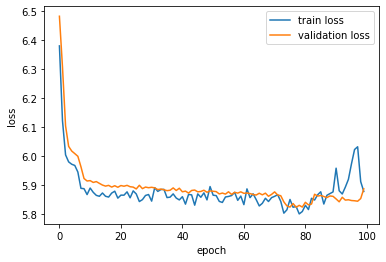

In [0]:
import matplotlib.pyplot as plt

plt.plot(total_valid_loss, label='train loss')
plt.plot(total_train_loss, label='validation loss')
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
img_path = os.path.join('/gdrive/My Drive/my_data/library/checkpoints/', "encoded_midi_6-1.png")
plt.savefig(img_path)

In [0]:
# Training
max_epochs = 100
n_iter = 0

# each 50 iterations we are going to compare the losses
total_train_loss = []
total_valid_loss = []

for e in range(max_epochs):
    model.train()
    random.shuffle(train_data)
    train_loss = []
    for b_train, batch in enumerate(batched_learning(train_data, batch_size=batch_size)):        
        
        n_iter += 1
        # train phase
        # feed data into the network and get outputs.
        inputs, target = batch
        
        #print(inputs.shape, target.shape)

        # Train on GPU
        inputs = (tensorFromSequence(inputs)).to(device)
        target = (tensorFromSequence(target)).to(device)

        # Create mask for both input and target sequences
        input_mask, target_mask = create_masks(inputs, target, pad_token)

        inputs = inputs[:,0,:]
        target = target[:,0,:] 

        ys = target.contiguous().view(-1)              

        # ys = labels.contiguous().view(-1).to(torch.long).to(device)
        
        # feed data into the network and get outputs.
        preds_idx = model(inputs, target, input_mask, target_mask)
        
        # Flush out gradients computed at the previous step before computing gradients at the current step. 
        #       Otherwise, gradients would accumulate.
        optimizer.zero_grad()

        # calculate loss
        loss = F.cross_entropy(preds_idx.contiguous().view(preds_idx.size(-1), -1).transpose(0,1), ys, ignore_index = pad_token, size_average = False) / (count_nonpad_tokens(ys))

        # accumulates the gradient and backprogate loss.
        loss.backward()

        # performs a parameter update based on the current gradient
        scheduler.step()    
        
        print('\n====================================================')
        print('Epoch/Batch: {}/{}'.format(e, b_train))
        print('Train >>>> Loss: {:6.6}'.format(loss))

        train_loss.append(loss.item())

    print('\n**************************************************')
    print("\n*** Test *** ")
    
    # Validation step
    model.eval()
    valid_loss = []
    with torch.no_grad():
        pair = valid_data
        inputs = tensorFromSequence(pair[0]).to(device)
        target = tensorFromSequence(pair[1]).to(device)
        
        # Create mask for both input and target sequences
        input_mask, target_mask = create_masks(inputs, target, pad_token)

        inputs = inputs[:,0,:]
        target = target[:,0,:] 
        ys = target.contiguous().view(-1)

        preds_validate = model(inputs, target, input_mask, target_mask)
        loss = F.cross_entropy(preds_validate.contiguous().view(preds_validate.size(-1), -1).transpose(0,1), ys, \
                                ignore_index = pad_token, size_average = False) / (count_nonpad_tokens(ys))
        valid_loss.append(loss.item())

    avg_train_loss = np.mean(train_loss)
    avg_valid_loss = np.mean(valid_loss)

    total_train_loss.append(avg_train_loss)
    total_valid_loss.append(avg_valid_loss)

    print("[Average Train Loss]: {:6.6}".format(avg_train_loss))
    print("[Average Testing Loss]: {:6.6}".format(avg_valid_loss))

    # save checkpoint whenever there is improvement in performance
    if avg_valid_loss < best_loss:
        best_loss = avg_valid_loss
        # Note: optimizer also has states ! don't forget to save them as well.
        ckpt = {'my_model':model.state_dict(),
                'optimizer':optimizer.state_dict(),
                'best_loss':best_loss}
        torch.save(ckpt, ckpt_path)
        print('checkpoint is saved !')

    train_writer.add_scalar('loss/train', avg_train_loss, global_step=n_iter)
    test_writer.add_scalar('loss/valid', avg_valid_loss, global_step=n_iter)
    print('\n**************************************************')
    # torch.cuda.empty_cache()
    # torch.save(model.state_dict(), '/gdrive/My Drive/my_data/library/checkpoints/train-{}.pt'.format(e))
    ckpt = {'my_model':model.state_dict(),
            'optimizer':optimizer.state_dict(),
            'best_loss':best_loss}
    torch.save(model.state_dict(), ckpt_backup_path)
    torch.save(ckpt, ckpt_fullbackup_path)

train_writer = SummaryWriter()
test_writer = SummaryWriter()

In [0]:
import matplotlib.pyplot as plt

plt.plot(total_train_loss, label='train loss')
plt.plot(total_valid_loss, label='validation loss')
plt.legend()

img_path = os.path.join('/gdrive/My Drive/my_data/library/checkpoints/', "losses_5-6.png")
plt.savefig(img_path)

In [0]:
batch =         


In [0]:
for batch in batched_learning(train_data, batch_size=batch_size):
    inputs, target = batch
    inputs = tensorFromSequence(inputs).to(device)
    target = tensorFromSequence(target).to(device)

    print(max(max((inputs[0]))))

In [0]:
# Filename: Beam.py
# Date Created: 15-Mar-2019 2:42:12 pm
# Description: Functions used for beam search.

def init_vars(src, model):
    # outputs used for the decoder is the starting pitches
    outputs = src

    # encoder pass
    src_mask = (src != pad_token).unsqueeze(-2).to(device)
    e_output = model.encoder(src, src_mask)

    # decoder pass
    trg_mask = nopeak_mask(src.shape[1])
    print(src_mask.size(), trg_mask.size())
    out = model.decoder(outputs, e_output, src_mask, trg_mask)
    out = model.linear(out)

    # final fc layer
    out = F.softmax(out, dim=-1)

    # calculate probablites for beam search
    # takes the last output from the model, hence out[:, -1]
    probs, ix = out[:, -1].data.topk(3)
    log_scores = torch.Tensor([math.log(prob) for prob in probs.data[0]]).unsqueeze(0)

    # store the model outputs
    outputs = torch.zeros(3, sequence_length).long().to(device)
    outputs[:, 0:src.shape[1]] = src
    outputs[:, src.shape[1]] = ix[0]

    # store the encoder output to be used later
    e_outputs = torch.zeros(3, e_output.size(-2),e_output.size(-1)).to(device)
    e_outputs[:, :] = e_output[0]

    return outputs, e_outputs, log_scores

def k_best_outputs(outputs, out, log_scores, i, k):
    # calculate probablities for each step in the sequence
    probs, ix = out[:, -1].data.topk(k)
    log_probs = torch.Tensor([math.log(p) for p in probs.data.view(-1)]).view(k, -1) + log_scores.transpose(0,1)
    k_probs, k_ix = log_probs.view(-1).topk(k)

    row = k_ix // k
    col = k_ix % k

    # update outputs
    outputs[:, :i] = outputs[row, :i]
    outputs[:, i] = ix[row, col]

    log_scores = k_probs.unsqueeze(0)

    return outputs, log_scores

def beam_search(src, model):
    outputs, e_outputs, log_scores = init_vars(src, model)
    init_start_len = outputs.shape[0]
    src_mask = (src != pad_token).unsqueeze(-2).to(device)

    for i in range(init_start_len, sequence_length):
        # Just comment this block of code if only use encoder once at the start
        src_mask = (outputs[0,:i].unsqueeze(-2) != pad_token).unsqueeze(-2).to(device)
        e_output = model.encoder(outputs[0,:i].unsqueeze(-2), src_mask)
        e_outputs = torch.zeros(3, e_output.size(-2),e_output.size(-1)).to(device)
        e_outputs[:, :] = e_output[0]
        print(outputs.size())
        trg_mask = nopeak_mask(i, )
        out = model.linear(model.decoder(outputs[:,:i], e_outputs, src_mask, trg_mask))
        out = F.softmax(out, dim=-1)

        outputs, log_scores = k_best_outputs(outputs, out, log_scores, i, 3)

    # return the one with the largest log_scores
    return outputs[0]

In [0]:
# Filename: Process.py
# Date Created: 17-Mar-2019 5:43:02 pm
# Description: Functions used for basic processes.
import numpy as np
import copy

def IndexToPitch(input, vocab):
    """
    Converts the index values from model's output back to pitches from vocab.
    """
    index_vocab = np.arange(len(vocab))
    output = input.clone()

    for i, val in reversed(list(enumerate(index_vocab))):
        output[output==val] = vocab[i]

    return output

def ProcessModelOutput(model_output):
    """
    Remove custom tokens and set rest tokens to NaN values
    Converts the model's output into numpy format similar to JSB dataset.
    """
    # Values for the custom tokens
    rest_token = 0
    pad_token = 1
    sos_token = 2
    eos_token = 3

    # Convert tensor to numpy
    output = model_output.cpu().detach().numpy()

    # Replace all pad tokens with rest tokens
    output[output==pad_token] = rest_token

    # Change rest tokens to NaN values
    output = np.where(output==rest_token, np.nan, output)

    # Reshape output to match JSB dataset
    output = output.reshape(round(output.shape[0]/4),4)

    return output

def get_len(train):
    for i, b in enumerate(train):
        pass

    return i

In [0]:
def generate(model):
    print("generating music using beam search...")
    model.eval()

    # choose 2 random pitches within the vocab (except rest/pad token) to start the sequence
    starting_pitch = torch.randint(2, len(vocab)-1, (2,)).unsqueeze(1).transpose(0,1).to(device)

    # generate the sequence using beam search
    generated_seq = beam_search(starting_pitch, model)

    # Make the index values back to original pitch
    output_seq = IndexToPitch(generated_seq, vocab)

    # Process the output format such that it is the same as our dataset
    processed = ProcessModelOutput(output_seq)

    return processed


In [0]:
d_model = 512
nhead = 8
dim_feedforward = 2048
dropout = 0.2
num_layer = 6
batch_size = 8
sequence_length = 1024
warmup_steps = 4000
pad_token = 1   
vocabulary_size = 48

normalization = torch.nn.LayerNorm(d_model)

custom_encoder_layer = MusicTransformerEncoderLayer(d_model=d_model, nhead=nhead, 
                                               dim_feedforward=dim_feedforward, 
                                               dropout=dropout, activation="relu")

custom_decoder_layer = MusicTransformerDecoderLayer(d_model=d_model, nhead=nhead, 
                                               dim_feedforward=dim_feedforward, 
                                               dropout=dropout, activation="relu")

custom_encoder = MusicTransformerEncoder(custom_encoder_layer, vocabulary_size, num_layer, normalization)
custom_decoder = MusicTransformerDecoder(custom_decoder_layer, vocabulary_size, num_layer, normalization)

model = MusicTransformer(d_model=d_model, nhead=nhead, 
                         vocabulary_size=vocabulary_size, 
                         num_encoder_layers=num_layer, 
                         num_decoder_layers=num_layer, 
                         dim_feedforward=dim_feedforward, 
                         dropout=dropout, activation="relu", 
                         custom_encoder=custom_encoder, 
                         custom_decoder=custom_decoder)
# Give model to the current device (hopefully cuda)
model.to(device)


MusicTransformer(
  (encoder): MusicTransformerEncoder(
    (layers): ModuleList(
      (0): MusicTransformerEncoderLayer(
        (self_attn): MusicMultiheadAttention(
          (out_proj): Linear(in_features=512, out_features=512, bias=True)
          (weights_q): Linear(in_features=512, out_features=512, bias=True)
          (weights_k): Linear(in_features=512, out_features=512, bias=True)
          (weights_v): Linear(in_features=512, out_features=512, bias=True)
          (weights_o): Linear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
     

In [0]:
model_name = '6-4'
ckpt_path = '/gdrive/My Drive/my_data/library/checkpoints/train-nlayer_'+model_name+'.pt'
ckpt_backup_path = '/gdrive/My Drive/my_data/library/checkpoints/train-backup-nlayer_'+model_name+'.pt'
ckpt_fullbackup_path = '/gdrive/My Drive/my_data/library/checkpoints/train-fullbackup-nlayer_'+model_name+'.pt'
if os.path.exists(ckpt_path):
    ckpt = torch.load(ckpt_path)
    try:
      model.load_state_dict(ckpt['my_model'])
      optimizer.load_state_dict(ckpt['optimizer'])
      best_acc = ckpt['best_loss']
    except RuntimeError as e:
        print('wrong checkpoint')
    else:    
      print('checkpoint is loaded !')
      print('current best loss : %.2f' % best_loss)

wrong checkpoint


In [0]:
# Generate the vocabulary from the data
vocab = GenerateVocab(src_data)
pad_token = 1

# counter to keep track of how many outputs have been saved
save_counter = 0

# Now lets generate some music
generated_music = generate(model)

generating music using beam search...
torch.Size([1, 2])
torch.Size([1, 1, 2]) torch.Size([1, 2, 2])


RuntimeError: ignored